In [1]:
from federated_models import FederatedLogisticRegression, federated_training
from local_logistic import LocalLogisticModel
from plots import plot_coeff_evolution, compare_logistic_models, cross_evaluate_heatmap
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
import os

In [2]:
df_fr = pd.read_csv("../data/french_data.csv").dropna()
df_be = pd.read_csv("../data/belgium_data.csv").dropna()
df_eu = pd.read_csv("../data/european_data.csv").dropna()
df_split = [df_fr, df_be, df_eu]
client_names = ["France", "Belgique", "Europe"]

local_epochs = 10
n_rounds = 10

In [3]:
def main_federated_evaluation():
    os.makedirs("results", exist_ok=True)
    os.makedirs("results/comparaison_models", exist_ok=True)
    os.makedirs("results/coeffs_evolution", exist_ok=True)
    
    # Initialisation des clients
    client_dicts = []
    for i, df in enumerate(df_split):
        client_dicts.append({
            "name": client_names[i],
            "lr": FederatedLogisticRegression(df, local_epochs=local_epochs),
            "coefs": None
        })

    # Apprentissage fédéré
    clients_history, global_history = federated_training(client_dicts, n_rounds=n_rounds, local_epochs=local_epochs)

    # Stockage heatmap
    local_model_dict = {}
    saved_auc_diagonal = {}
    saved_auc_federated = {}

    for i, name in enumerate(client_names):
        print(f"\n🔵 Évaluation du client : {name}")
        df = df_split[i]

        # local
        local_model = LocalLogisticModel(df)
        local_model.train()
        local_model_dict[name] = local_model

        y_true = local_model.y_test
        y_scores_local = local_model.predict_proba()
        coefs_local = local_model.get_coefficients()
        exposure_test = local_model.exposure_test

        auc_local = roc_auc_score(y_true, y_scores_local, sample_weight=exposure_test)
        ap_local = average_precision_score(y_true, y_scores_local, sample_weight=exposure_test)
        saved_auc_diagonal[name] = auc_local

        # global (FedAvg)
        fed_model = client_dicts[i]["lr"]
        fed_model.set_coefficients(global_history[-1])
        coefs_global = fed_model.get_coefficients()

        X_scaled = local_model.scaler.transform(local_model.X_test)
        y_scores_global = fed_model.model.predict_proba(X_scaled)[:, 1] * exposure_test.values

        auc_global = roc_auc_score(y_true, y_scores_global, sample_weight=exposure_test)
        ap_global = average_precision_score(y_true, y_scores_global, sample_weight=exposure_test)
        saved_auc_federated[name] = auc_global

        print(f"🧪 AUC Local: {auc_local:.4f} — AUC Global: {auc_global:.4f}")

        # Graphe comparaison
        fig = plt.figure(figsize=(14, 12))
        compare_logistic_models(
            y_true=y_true,
            y_scores_local=y_scores_local,
            coeff_dict_local=coefs_local,
            y_scores_global=y_scores_global,
            coeff_dict_global=coefs_global,
            name=name,
            auc_local=auc_local,
            auc_global=auc_global,
            ap_local=ap_local,
            ap_global=ap_global,
            save_path=f"results/comparaison_models/comparaison_{name.lower()}.png" 
        )


    # Heatmap croisée
    cross_evaluate_heatmap(
        client_names=client_names,
        df_split=df_split,
        local_models=local_model_dict,
        saved_auc_diagonal=saved_auc_diagonal,
        saved_auc_federated=saved_auc_federated
    )

    # Évolution des coefficients
    features = ["Power", "DriverAge", "Fuel_type", "Density", "Sex", "Intercept"]
    for feature in features:
        plt.figure(figsize=(12, 6))
        plot_coeff_evolution(clients_history, global_history, coef_name=feature, client_names=client_names)
        path = f"results/coeffs_evolution/evolution_{feature}.png"
        plt.savefig(path)
        plt.close()
        print(f" Courbe de '{feature}' sauvegardée : {path}")

    print("\n✅ Tous les résultats sauvegardés dans 'results/'")




--- Round fédéré 1/10---
--> France - Entraînement local
🔍 Meilleurs hyperparams pour ce client : {'C': np.float64(0.0001), 'penalty': 'l2', 'solver': 'lbfgs'}
--> Belgique - Entraînement local
🔍 Meilleurs hyperparams pour ce client : {'C': np.float64(0.0001), 'penalty': 'l2', 'solver': 'lbfgs'}
--> Europe - Entraînement local
🔍 Meilleurs hyperparams pour ce client : {'C': np.float64(0.005994842503189409), 'penalty': 'l2', 'solver': 'lbfgs'}

📊 Poids des datasets dans la moyenne fédérée :
 - France: 30.09%
 - Belgique: 4.50%
 - Europe: 65.41%

--- Round fédéré 2/10---
--> France - Entraînement local
--> Belgique - Entraînement local
--> Europe - Entraînement local

📊 Poids des datasets dans la moyenne fédérée :
 - France: 30.09%
 - Belgique: 4.50%
 - Europe: 65.41%

--- Round fédéré 3/10---
--> France - Entraînement local
--> Belgique - Entraînement local
--> Europe - Entraînement local

📊 Poids des datasets dans la moyenne fédérée :
 - France: 30.09%
 - Belgique: 4.50%
 - Europe: 65.

/Users/nayelbenabdesadok/opt/anaconda3/envs/fed_learning/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


🧪 AUC Local: 0.5538 — AUC Global: 0.5420
✅ Figure sauvegardée dans results/comparaison_models/comparaison_france.png

🔵 Évaluation du client : Belgique
🧪 AUC Local: 0.5645 — AUC Global: 0.5399


/Users/nayelbenabdesadok/opt/anaconda3/envs/fed_learning/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Figure sauvegardée dans results/comparaison_models/comparaison_belgique.png

🔵 Évaluation du client : Europe


/Users/nayelbenabdesadok/opt/anaconda3/envs/fed_learning/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


🧪 AUC Local: 0.5729 — AUC Global: 0.5697
✅ Figure sauvegardée dans results/comparaison_models/comparaison_europe.png


/Users/nayelbenabdesadok/GitProjects/Federated_Learning_Milliman/code/plots.py:105: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/nayelbenabdesadok/GitProjects/Federated_Learning_Milliman/code/plots.py:106: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  plt.savefig("results/heatmap_auc_croisée.png")


<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

/Users/nayelbenabdesadok/opt/anaconda3/envs/fed_learning/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


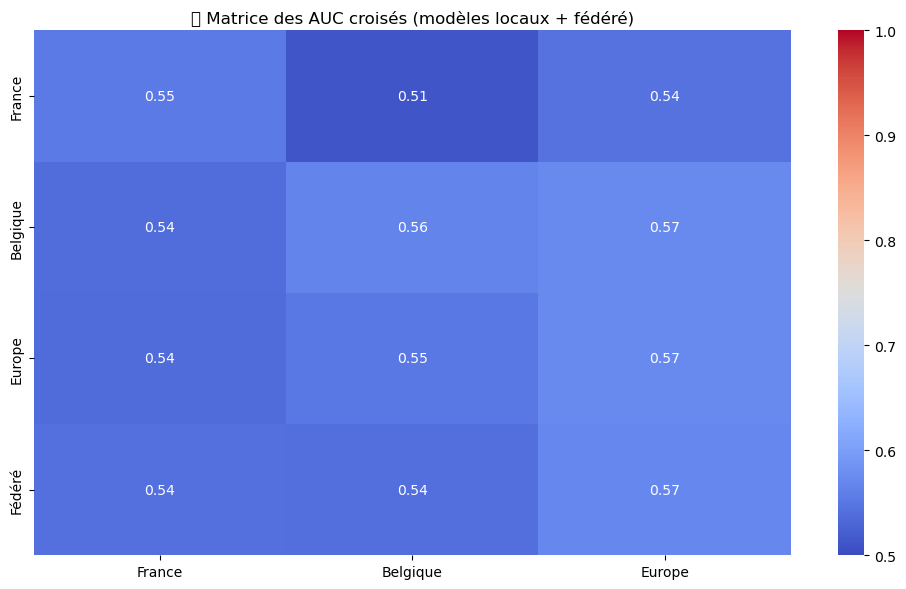

 Courbe de 'Power' sauvegardée : results/coeffs_evolution/evolution_Power.png
 Courbe de 'DriverAge' sauvegardée : results/coeffs_evolution/evolution_DriverAge.png
 Courbe de 'Fuel_type' sauvegardée : results/coeffs_evolution/evolution_Fuel_type.png
 Courbe de 'Density' sauvegardée : results/coeffs_evolution/evolution_Density.png
 Courbe de 'Sex' sauvegardée : results/coeffs_evolution/evolution_Sex.png
 Courbe de 'Intercept' sauvegardée : results/coeffs_evolution/evolution_Intercept.png

✅ Tous les résultats sauvegardés dans 'results/'


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [4]:
main_federated_evaluation()